In [1]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import numexpr as ne
import math
import timeit
import jax.numpy as jnp
import matplotlib.pyplot as plt
import timeit
import functools


In [28]:
import timeit
import functools

def timeit_decorator(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        start_time = timeit.default_timer()
        result = func(*args, **kwargs)
        end_time = timeit.default_timer()
        print(f"Function {func.__name__} took {end_time - start_time} seconds to run.")
        return result
    return wrapper

/var/folders/j1/w77jn90n4xz0jc6gqk110_x00000gn/T/ipykernel_35755/1329323854.py:12: RuntimeWarning: invalid value encountered in log
  x = np.log(np.log2(abs(cheker)))


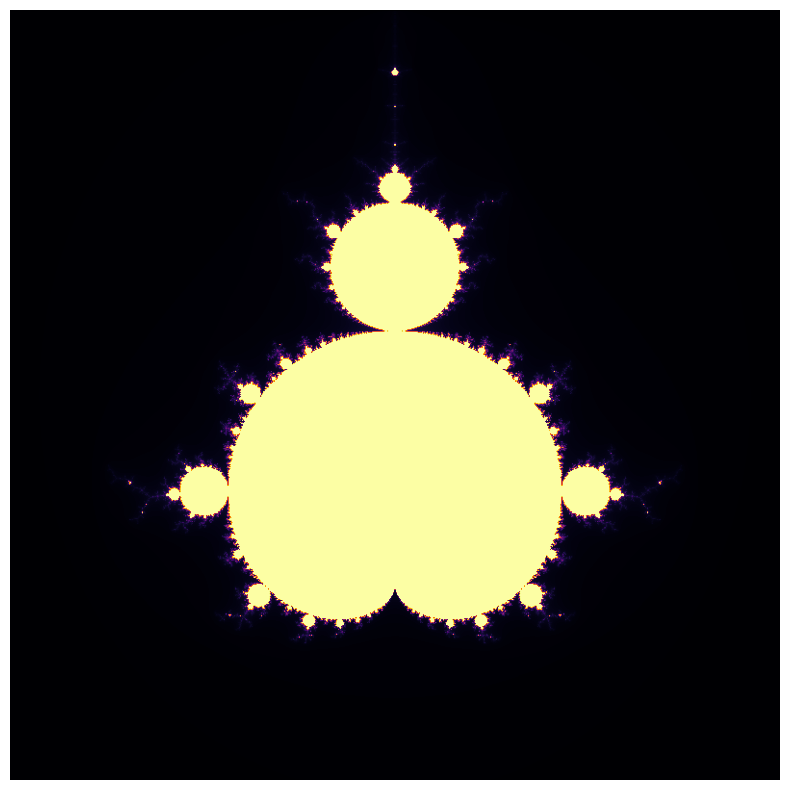

In [300]:

# function to check if number is in mondelbrot set
def mandelbrot_check_vect(c, max_iter):
    cheker = jnp.zeros(c.shape, dtype=complex)
    hit = jnp.zeros(c.shape, dtype=int)

    for _ in range(max_iter):
        mask = jnp.abs(cheker) <= 2
        cheker = ne.evaluate('where(mask, cheker**2 + c, cheker)')
        hit = ne.evaluate('where(mask, hit + 1, hit)')

    # grad calculation for each point
    x = np.log(np.log2(abs(cheker)))
    mask_GR = ne.evaluate('hit < max_iter')
    gradient = ne.evaluate('where(mask_GR, hit + 1 - x, hit)')
    return gradient

# drawing the Mandelbrot set
width, height = 800, 800
x = np.linspace(-2, 1, width)
y = np.linspace(-1.5, 1.5, height)
c = x[:, None] + 1j*y[None, :]

mandelbrot_image = mandelbrot_check_vect(c, 300)

plt.figure(figsize=(10, 10))
plt.imshow(mandelbrot_image, cmap='inferno')
plt.axis('off')
plt.show()


In [ ]:
total_samples = 10**6
max_iter = 500
num_cores = 9
smaples = [10**6]
iters = [100]
num_simulations = 100
simulation_res = []
result = []
for iter in iters:
    simulation_result = [result_extraction_simple(total_samples, iter, num_cores) for _ in range(num_simulations)]
    print(simulation_result)
    simulation_res.append(simulation_result)
    mean_resul = np.mean(simulation_result)
    std_deviatio = np.std(simulation_result)
    result.append((mean_resul, std_deviatio))

result


In [97]:
# Here I create samples and check whether they are in mandelbrot set. I use jnp and numexpr for multithreading, 
# numpy for vectorisation and joblib for multiprocessing. Overall 11.5 times faster then area_mandel
def area_mandel_vect_numexpr(n_sampl, max_iter):
    x_min, x_max, y_min, y_max = -2, 1, -1.5, 1.5
    x = np.random.uniform(x_min, x_max, n_sampl)
    y = np.random.uniform(y_min, y_max, n_sampl)
    c = ne.evaluate("x + 1j * y")
    cheker = jnp.zeros(c.shape, dtype=complex)
    hit = jnp.zeros(c.shape, dtype=int)
    for _ in range(max_iter):
        mask = jnp.abs(cheker) <= 2
        cheker = ne.evaluate('where(mask, cheker**2 + c, cheker)')
        hit = ne.evaluate('where(mask, hit + 1, hit)')
    return jnp.sum(mask), n_sampl
# Here I extract results and combine them to calculate area
def result_extraction_simple_numexpr(total_samples, max_iter, num_cores):
    samples_per_core = total_samples // num_cores
    results = Parallel(n_jobs=num_cores)(
        delayed(area_mandel_vect_numexpr)(samples_per_core, max_iter) for core in range(num_cores)
    )
    hits = jnp.sum(np.fromiter((hit for hit, _ in results), dtype=float))
    samples = jnp.sum(np.fromiter((sampler for _, sampler in results), dtype=float))
    x_min, x_max, y_min, y_max = -2, 1, -1.5, 1.5
    area = (x_max - x_min) * (y_max - y_min) * (hits / samples)
    return area

In [84]:
area_estimate = result_extraction_simple_numexpr(10**6, 1000, 1)
print("Estimated area:", area_estimate)

1000000.0
Estimated area: 1.508031


In [101]:
max_iter = 300
num_cores = 10
total_samples = (10**5)*2
res_latin_hypercube = [result_extraction_simple_numexpr(total_samples, max_iter, num_cores) for _ in range(100)]
std_latin_hypercube= np.std(res_latin_hypercube)
mean_latin_hypercube = np.mean(res_latin_hypercube)
print(f"Mean is {mean_latin_hypercube}, Sdt is {std_latin_hypercube}")

Mean is 1.5199410915374756, Sdt is 0.00806897971779108


In [92]:
# Here I create samples and check whether they are in mandelbrot set. I use jnp and numexpr for multithreading, 
# numpy for vectorisation and joblib for multiprocessing. Overall 11.5 times faster then area_mandel
def area_mandel_vect_numexp_antithetic(n_sampl, max_iter):
    x_min, x_max, y_min, y_max = -2, 1, -1.5, 1.5
    x = np.random.uniform(0, 1, n_sampl)
    y = np.random.uniform(0, 1, n_sampl)
    f_antithetic = lambda x: 1-x
    x = np.append(x,list(map(f_antithetic,x)))
    y = np.append(y,list(map(f_antithetic,y)))
    x = x_min + x*(x_max-x_min)
    y = y_min + y*(y_max-y_min)
    c = ne.evaluate("x + 1j * y")
    cheker = np.zeros(c.shape, dtype=complex)
    hit = np.zeros(c.shape, dtype=int)
    for _ in range(max_iter):
        mask = np.abs(cheker) <= 2
        cheker = ne.evaluate('where(mask, cheker**2 + c, cheker)')
        hit = ne.evaluate('where(mask, hit + 1, hit)')
    #print(mask)
    return np.sum(mask), len(mask)
# Here I extract results and combine them to calculate area
def result_extraction_simple_numexpr_antithetic(total_samples, max_iter, num_cores):
    samples_per_core = total_samples // num_cores
    results = Parallel(n_jobs=num_cores)(
        delayed(area_mandel_vect_numexp_antithetic)(samples_per_core, max_iter) for core in range(num_cores)
    )
    hits = np.sum(np.fromiter((hit for hit, _ in results), dtype=float))
    #print(hits)
    samples = np.sum(np.fromiter((sampler for _, sampler in results), dtype=float))
    #print(samples)
    x_min, x_max, y_min, y_max = -2, 1, -1.5, 1.5
    area = (x_max - x_min) * (y_max - y_min) * (hits / (samples))
    return area

In [89]:
area_estimate = result_extraction_simple_numexpr_antithetic(int((10**6)/2), 1000, 10)
print("Estimated area:", area_estimate)

1000000.0
Estimated area: 1.506879


In [102]:
max_iter = 300
num_cores = 10
total_samples = 10**5
res_latin_hypercube = [result_extraction_simple_numexpr_antithetic(total_samples, max_iter, num_cores) for _ in range(100)]
std_latin_hypercube= np.std(res_latin_hypercube)
mean_latin_hypercube = np.mean(res_latin_hypercube)
print(f"Mean is {mean_latin_hypercube}, Sdt is {std_latin_hypercube}")

Mean is 1.5221043, Sdt is 0.009090542256103324


In [74]:
execution_time = timeit.timeit(lambda: result_extraction_simple_numexpr_antithetic(10**6, 1000, 10), number=20)
print(f"Average execution time over 10 runs: {execution_time/20} seconds")

Average execution time over 10 runs: 2.8832639416563324 seconds


In [1370]:
execution_time = timeit.timeit(lambda: area_mandel(10**6, 1000), number=2)
print(f"Average execution time over 10 runs: {execution_time/2} seconds")


Average execution time over 10 runs: 14.019558812491596 seconds


In [11]:
# TODO: Change logic of list creation to optimise and use jnp
def stratified_sampling(n_sampl, max_iter, num ):
    x_min, x_max, y_min, y_max = -2, 0.5, -1.5, 1.5
    x_len = x_max - x_min
    y_len = y_max - y_min
    x_h = x_len / num
    y_h = y_len / num
    x_array = np.array([x_min + x_h * a for a in range(num + 1)])
    y_array = np.array([y_min + y_h * a for a in range(num + 1)])
    x_samples = []
    y_samples = []
    for a in range(num):
        x_samples.extend(np.random.uniform(x_array[a], x_array[a + 1], n_sampl // num))
        y_samples.extend(np.random.uniform(y_array[a], y_array[a + 1], n_sampl // num))
    np.random.shuffle(y_samples)
    x_samples = np.array(x_samples)
    y_samples = np.array(y_samples)
    c = x_samples + 1j * y_samples
    #print(c[0])
    cheker = np.zeros(c.shape, dtype=complex)
    hit = np.zeros(c.shape, dtype=float)
    for _ in range(max_iter):
        mask = np.abs(cheker) <= 2
        cheker = ne.evaluate('where(mask, cheker**2 + c, cheker)')
        hit = ne.evaluate('where(mask, hit + 1, hit)')
    return np.sum(mask == True), n_sampl

def result_extraction_stratifies(total_samples, max_iter, num_cores):
    samples_per_core = total_samples // num_cores
    results = Parallel(n_jobs=num_cores)(
        delayed(stratified_sampling)(samples_per_core, max_iter, 8) for core in range(num_cores)
    )
    #print(results)
    hits = np.sum(np.fromiter((hit for hit, _ in results), dtype=float))
    #print(hits)
    samples = np.sum(np.fromiter((sampler for _, sampler in results), dtype=float))
    #print(samples)
    x_min, x_max, y_min, y_max = -2, 0.5, -1.5, 1.5
    area = (x_max - x_min) * (y_max - y_min) * (hits / samples)
    return area

In [14]:
max_iter = 300
num_cores = 10
total_samples = (10**3)*2
res_stratifies = [result_extraction_stratifies(total_samples, max_iter, num_cores) for _ in range(100)]
std_stratifies= np.std(res_stratifies)
mean_stratifies = np.mean(res_stratifies)
print(f"Mean is {mean_stratifies}, Sdt is {std_stratifies}")

Mean is 1.5123000000000004, Sdt is 0.053376820812034084


(array([ 3.,  6., 18., 18., 20., 16.,  7.,  5.,  4.,  3.]),
 array([1.50540451, 1.50659791, 1.50779131, 1.50898471, 1.51017811,
        1.51137151, 1.51256491, 1.51375831, 1.51495171, 1.51614512,
        1.51733852]),
 <BarContainer object of 10 artists>)

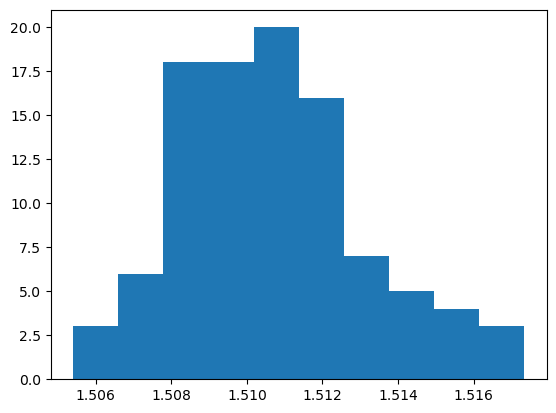

In [769]:
plt.hist(res_stratifies)

In [17]:
# TODO: Change logic of list creation to optimise and use jnp
def stratified_sampling_anti(n_sampl, max_iter, num ):
    x_min, x_max, y_min, y_max = -2, 1, 0, 1.5
    x_len = x_max - x_min
    y_len = y_max - y_min
    x_h = x_len / num
    y_h = y_len / num
    x_array = np.array([x_min + x_h * a for a in range(num + 1)])
    y_array = np.array([y_min + y_h * a for a in range(num + 1)])
    x_samples = []
    y_samples = []
    for a in range(num):
        x_samples.extend(np.random.uniform(x_array[a], x_array[a + 1], n_sampl // num))
        y_samples.extend(np.random.uniform(y_array[a], y_array[a + 1], n_sampl // num))
    np.random.shuffle(y_samples)
    x_samples = np.array(x_samples)
    y_samples = np.array(y_samples)
    x_point_anti , y_points_anti = anthithetic_variable(x_samples, y_samples)
    #print(min(y_points_anti))
    np.random.shuffle(x_point_anti)
    np.random.shuffle(y_points_anti)
    x_samples = np.append(x_samples, x_point_anti)
    y_samples = np.append(y_samples, y_points_anti)
    c = x_samples + 1j * y_samples
    #print(c[0])
    cheker = np.zeros(c.shape, dtype=complex)
    hit = np.zeros(c.shape, dtype=float)
    for _ in range(max_iter):
        mask = np.abs(cheker) <= 2
        cheker = ne.evaluate('where(mask, cheker**2 + c, cheker)')
        hit = ne.evaluate('where(mask, hit + 1, hit)')
    return np.sum(mask == True), n_sampl

def anthithetic_variable(x_point, y_point):
    bound_x = (-2, 0.5)
    bound_y = (-1.5, 1.5) 
    length_x = bound_x[1] - bound_x[0]
    length_y = bound_y[1] - bound_y[0]
    f_mirror = lambda bound, length, x : bound[1] - (x - bound[0])
    f_antithtic_x = lambda array: list(map(lambda x: f_mirror(bound_x, length_x, x), array))
    f_antithtic_y = lambda array: list(map(lambda x: f_mirror(bound_y, length_y, x), array))
    antith_x = f_antithtic_x(x_point)
    antith_y = f_antithtic_y(y_point)
    #print(max(antith_y))
    return antith_x, antith_y

def result_extraction_stratifies_anti(total_samples, max_iter, num_cores):
    samples_per_core = total_samples // num_cores
    results = Parallel(n_jobs=num_cores)(
        delayed(stratified_sampling_anti)(samples_per_core, max_iter, 8) for core in range(num_cores)
    )
    #print(results)
    hits = np.sum(np.fromiter((hit for hit, _ in results), dtype=float))
    #print(hits)
    samples = np.sum(np.fromiter((sampler for _, sampler in results), dtype=float))
    #print(samples)
    x_min, x_max, y_min, y_max = -2, 1, 0, 1.5
    area = (x_max - x_min) * (y_max - y_min) * (hits / samples)
    return area*2

In [18]:
max_iter = 300
num_cores = 10
total_samples = (10**3)*2
res_stratifies = [result_extraction_stratifies(total_samples, max_iter, num_cores) for _ in range(100)]
std_stratifies= np.std(res_stratifies)
mean_stratifies = np.mean(res_stratifies)
print(f"Mean is {mean_stratifies}, Sdt is {std_stratifies}")

Mean is 1.5153, Sdt is 0.049439394717168586


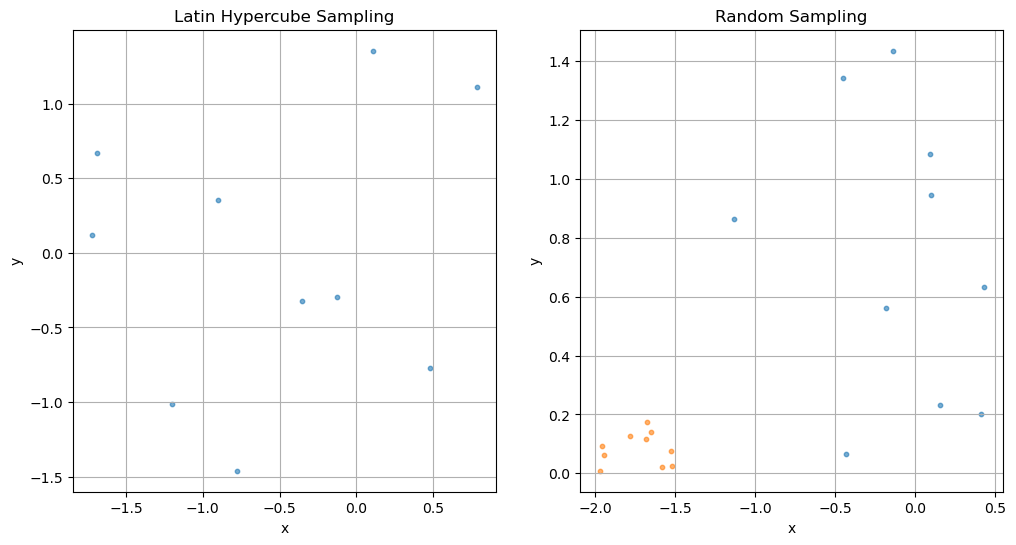

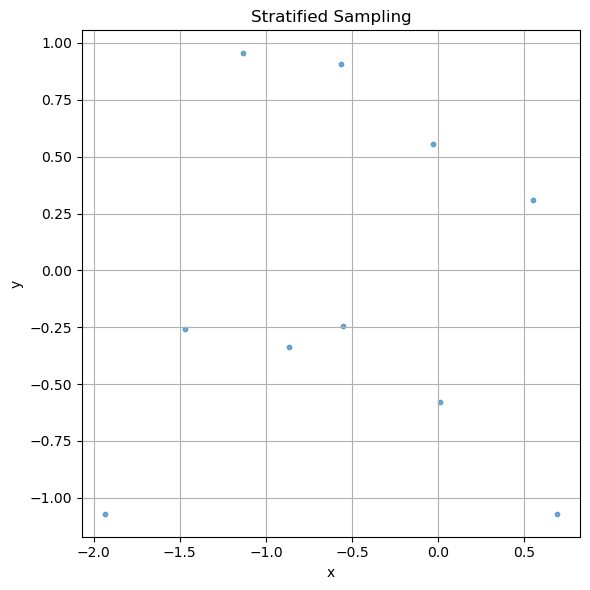

ValueError: x and y must be the same size

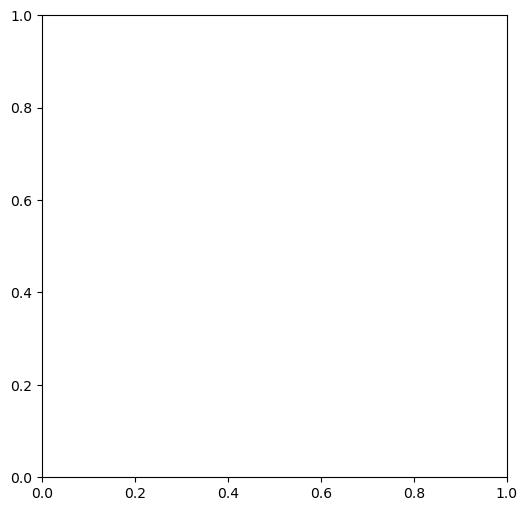

In [804]:

def latin_hypercube_sampling(n_sampl):
    x_min, x_max, y_min, y_max = -2, 1, -1.5, 1.5
    x_len = x_max - x_min
    y_len = y_max - y_min
    x_h = x_len / n_sampl
    y_h = y_len / n_sampl
    x_array = np.array([x_min + x_h * a for a in range(n_sampl + 1)])
    y_array = np.array([y_min + y_h * a for a in range(n_sampl + 1)])
    x = np.array([np.random.uniform(x_array[a], x_array[a + 1], 1) for a in range(n_sampl)])
    y = np.array([np.random.uniform(y_array[a], y_array[a + 1], 1) for a in range(n_sampl)])
    np.random.shuffle(y)
    
    return x, y
def random_sampling(n_sampl):
    x_min, x_max, y_min, y_max = -1.5, 0.5, 0, 1.5
    x = np.random.uniform(x_min, x_max, n_sampl)
    y = np.random.uniform(y_min, y_max, n_sampl)
    return x, y
def area_mandel_vect_1(n_sampl):
    x_min, x_max, y_min, y_max = -2, -1.5, 0, 0.2
    x = np.random.uniform(x_min, x_max, n_sampl)
    y = np.random.uniform(y_min, y_max, n_sampl)
    return x, y
def stratified_sampling(n_sampl, num):
    x_min, x_max, y_min, y_max = -2, 1, -1.5, 1.5
    x_len = x_max - x_min
    y_len = y_max - y_min
    x_h = x_len / num
    y_h = y_len / num
    x_array = np.array([x_min + x_h * a for a in range(num + 1)])
    y_array = np.array([y_min + y_h * a for a in range(num + 1)])
    x_samples = []
    y_samples = []
    for a in range(num):
        x_samples.extend(np.random.uniform(x_array[a], x_array[a + 1], n_sampl // num))
        y_samples.extend(np.random.uniform(y_array[a], y_array[a + 1], n_sampl // num))
    np.random.shuffle(y_samples)
    return np.array(x_samples), np.array(y_samples)
n_sampl = 10

x_lhs, y_lhs = latin_hypercube_sampling(n_sampl)
array1 = np.array([-2, -1.7, -1.4, -1.1, -0.8, -0.5, -0.2, 0.1, 0.4, 0.7, 1])
array2 = np.array([0, 0.15, 0.3, 0.45, 0.6, 0.75, 0.9, 1.05, 1.2, 1.35, 1.5])

pairs = np.array(np.meshgrid(array1, array2)).T.reshape(-1, 2) 
xf = pairs[0:,0]
yf = pairs[0,0:]
x_random, y_random = random_sampling(n_sampl)
x_rand, y_rand = area_mandel_vect_1(n_sampl)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(x_lhs, y_lhs, alpha=0.6, s=10)  
plt.title('Latin Hypercube Sampling')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(x_random, y_random, alpha=0.6, s=10)  
plt.scatter(x_rand, y_rand, alpha=0.6, s=10)  

plt.title('Random Sampling')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)

n_sampl = 10
num =5

x_stratified, y_stratified = stratified_sampling(n_sampl, num)

plt.figure(figsize=(6, 6))
plt.scatter(x_stratified, y_stratified, alpha=0.6, s=10)
plt.title('Stratified Sampling')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.tight_layout()
plt.show()
plt.figure(figsize=(6, 6))
plt.scatter(xf, yf, alpha=0.6, s=10)
plt.title('Stratified Sampling')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.tight_layout()
plt.show()

In [483]:
def latin_hypercube_sampling(n, d):
    lower_limits = np.arange(0, n, dtype=float) / n
    upper_limits = np.arange(1, n + 1, dtype=float) / n
    print(upper_limits)
    random_points = np.random.uniform(low=lower_limits, high=upper_limits, size=(d, n)).T
    #np.random.shuffle(random_points[:, 1])
    return random_points

latin_hypercube_sampling(10, 5)

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


array([[0.01232664, 0.09222849, 0.01684971, 0.00800631, 0.07634105],
       [0.1903359 , 0.12053517, 0.17603234, 0.17852332, 0.17070732],
       [0.23760611, 0.21207114, 0.28119329, 0.2146504 , 0.23635583],
       [0.31238609, 0.33653902, 0.32446393, 0.35714989, 0.32097271],
       [0.45840502, 0.43122682, 0.4005949 , 0.46062886, 0.4975402 ],
       [0.59970198, 0.50141009, 0.50734678, 0.52333714, 0.50664735],
       [0.62345044, 0.66574191, 0.62240902, 0.63961107, 0.67794866],
       [0.77124911, 0.78950555, 0.74453919, 0.72132328, 0.77835287],
       [0.82124282, 0.80989938, 0.80928971, 0.84818386, 0.87340708],
       [0.9478646 , 0.98100945, 0.95494092, 0.98835478, 0.96416857]])

In [79]:
import timeit
execution_time = timeit.timeit(lambda: result_extraction(10**7, 500, 8), number=4)
print(f"Average execution time over 10 runs: {execution_time/4} seconds")

Average execution time over 10 runs: 8.735422104015015 seconds


In [15]:
def generate_samples(n_sampl, minmax):
    #print(n_sampl)
    xmin , xmax = minmax
    intervals = np.linspace(xmin, xmax, n_sampl+1)
    #print(intervals)
    f = lambda pair: np.random.uniform(pair[0], pair[1])
    mapflt = lambda f, xs: map(f, zip(xs, xs[1:]))
    points = list(mapflt(f, intervals))
    #print(points)
    return points
# TODO: maybe spreading x, y between two chunks of processors is faster??
def latin_hypercube_parallel(total_samples, dimensions, num_cores):
    samples_per_core = (total_samples) // (num_cores)
    x_strata_per_core = np.linspace(-2, 0.5, (num_cores+1))
    y_strata_per_core = np.linspace(-1.5, 1.5, (num_cores+1))
    #print(x_strata_per_core)
    f = lambda x , y : (x[y], x[y+1])
    results_x = Parallel(n_jobs=num_cores)(
        delayed(generate_samples)(samples_per_core, f(x_strata_per_core, core)) for core in range(num_cores)
    )
    #print(results_x)
    results_y = Parallel(n_jobs=num_cores)(
        delayed(generate_samples)(samples_per_core, f(y_strata_per_core, core)) for core in range(num_cores)
    )
    #print(results_y)
    combo_x = np.concatenate(results_x)
    #print(combined_samples_x)
    combo_y = np.concatenate(results_y)
    combo =  np.vstack((combo_x, combo_y))
    #print("combo: ", combo)
    return combo.T

def latin_hypercube_mandelbrot_check(chunk, max_iter):
    cheker = jnp.zeros(chunk.shape, dtype=complex)
    hit = jnp.zeros(chunk.shape, dtype=float)
    for _ in range(max_iter):
        mask = jnp.abs(cheker) <= 2
        cheker = ne.evaluate('where(mask, cheker**2 + chunk, cheker)')
        hit = ne.evaluate('where(mask, hit + 1, hit)')
    return jnp.sum(mask), len(chunk)

# TODO: really no need to save or pass totall samples
def latin_hypercube_parallel_mandelbrot(c, max_iter, num_cores):
    chunks = jnp.array_split(c, num_cores)
    results = Parallel(n_jobs=num_cores)(
        delayed(latin_hypercube_mandelbrot_check)(chunk, max_iter) for chunk in chunks
    )
    total_hits = jnp.sum(np.fromiter((hit for hit, _ in results), dtype=int))
    total_samples = jnp.sum(np.fromiter((sampl for _, sampl in results), dtype=int))

    return total_hits, total_samples

# TODO: could perhaps be merged with sample genrator since I dont scale it anymore
def transform_points_to_complex(points, x_min, x_max, y_min, y_max):
    #print(len(points))
    x_points = points[:, 0]
    y_points = points[:, 1]
    np.random.shuffle(y_points)
    return ne.evaluate('x_points + 1j * y_points')


def calculate_area_of_mandelbrot(total_samples, max_iter, num_cores, x_min, x_max, y_min, y_max):
    points = latin_hypercube_parallel(total_samples, 2, num_cores)
    #print(points)
    c = transform_points_to_complex(points, x_min, x_max, y_min, y_max)
    #print("c: ", c)
    hits, samples = latin_hypercube_parallel_mandelbrot(c, max_iter, num_cores)
    #print(samples)
    mandelbrot_area = (x_max - x_min) * (y_max - y_min) * (hits / samples)
    return mandelbrot_area

max_iter = 1000
num_cores = 8
total_samples = 10**6
x_min, x_max, y_min, y_max = -2, 0.5, -1.5, 1.5

area = calculate_area_of_mandelbrot(total_samples, max_iter, num_cores, x_min, x_max, y_min, y_max)
print(f"Estimated area of the Mandelbrot set: {area}")


I0000 00:00:1700189683.247210       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1700189683.614070       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1700189683.621512       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1700189683.627282       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1700189683.627371       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1700189683.629335       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1700189683.629568       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1700189683.635434       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1700189683.719973       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


Estimated area of the Mandelbrot set: 1.5128775835037231


In [16]:
max_iter = 300
num_cores = 10
total_samples = (10**3)*2
x_min, x_max, y_min, y_max = -2, 0.5, -1.5, 1.5
res_latin_hypercube = [calculate_area_of_mandelbrot(total_samples, max_iter, num_cores, x_min, x_max, y_min, y_max) for _ in range(100)]
std_latin_hypercube= np.std(res_latin_hypercube)
mean_latin_hypercube = np.mean(res_latin_hypercube)
print(f"Mean is {mean_latin_hypercube}, Sdt is {std_latin_hypercube}")

I0000 00:00:1700189690.306128       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1700189690.306128       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


Mean is 1.5142500400543213, Sdt is 0.04354524239897728


In [1361]:
execution_time = timeit.timeit(lambda: calculate_area_of_mandelbrot(total_samples, max_iter, num_cores, x_min, x_max, y_min, y_max), number=5)
print(f"Average execution time over 10 runs: {execution_time/5} seconds")

Average execution time over 10 runs: 1.5586683750152588 seconds


In [106]:
def generate_samples(n_sampl, minmax):
    #print(n_sampl)
    xmin , xmax = minmax
    intervals = np.linspace(xmin, xmax, n_sampl+1)
    #print(intervals)
    f = lambda pair: np.random.uniform(pair[0], pair[1])
    mapflt = lambda f, xs: map(f, zip(xs, xs[1:]))
    points = list(mapflt(f, intervals))
    #print(points)
    return points

# TODO: maybe spreading x, y between two chunks of processors is faster??
def latin_hypercube_parallel(total_samples, dimensions, num_cores):
    samples_per_core = round(total_samples / num_cores)
    x_strata_per_core = np.linspace(-2, 0.5, (num_cores+1))
    y_strata_per_core = np.linspace(-1.5, 1.5, (num_cores+1))
    #print(x_strata_per_core)
    f = lambda x , y : (x[y], x[y+1])
    results_x = Parallel(n_jobs=num_cores)(
        delayed(generate_samples)(samples_per_core, f(x_strata_per_core, core)) for core in range(num_cores)
    )
    #print(results_x)
    results_y = Parallel(n_jobs=num_cores)(
        delayed(generate_samples)(samples_per_core, f(y_strata_per_core, core)) for core in range(num_cores)
    )
    #print(results_y)
    combo_x = np.concatenate(results_x)
    #print(combined_samples_x)
    combo_y = np.concatenate(results_y)
    combo =  np.vstack((combo_x, combo_y))
    #print("combo: ", combo)
    return combo.T

def anthithetic_variable(x_point, y_point):
    bound_x = (-2, 0.5)
    bound_y = (-1.5, 1.5) 
    length_x = bound_x[1] - bound_x[0]
    length_y = bound_y[1] - bound_y[0]
    f_mirror = lambda bound, length, x : bound[1] - (x - bound[0])
    f_antithtic_x = lambda array: list(map(lambda x: f_mirror(bound_x, length_x, x), array))
    f_antithtic_y = lambda array: list(map(lambda x: f_mirror(bound_y, length_y, x), array))
    antith_x = f_antithtic_x(x_point)
    antith_y = f_antithtic_y(y_point)
    #print(max(antith_y))
    return antith_x, antith_y

def latin_hypercube_mandelbrot_check(chunk, max_iter):
    cheker = jnp.zeros(chunk.shape, dtype=complex)
    hit = jnp.zeros(chunk.shape, dtype=float)
    for _ in range(max_iter):
        mask = jnp.abs(cheker) <= 2
        cheker = ne.evaluate('where(mask, cheker**2 + chunk, cheker)')
        hit = ne.evaluate('where(mask, hit + 1, hit)')
    return jnp.sum(mask), len(chunk)

# TODO: really no need to save or pass totall samples but ? might fuckup if number of cores is odd ?
def latin_hypercube_parallel_mandelbrot(c, max_iter, num_cores):
    chunks = jnp.array_split(c, num_cores)
    results = Parallel(n_jobs=num_cores)(
        delayed(latin_hypercube_mandelbrot_check)(chunk, max_iter) for chunk in chunks
    )
    total_hits = jnp.sum(np.fromiter((hit for hit, _ in results), dtype=int))
    total_samples = jnp.sum(np.fromiter((sampl for _, sampl in results), dtype=int))

    return total_hits, total_samples

# TODO: could perhaps be merged with sample genrator since I dont scale it anymore
def transform_points_to_complex(points, x_min, x_max, y_min, y_max):
    #print(len(points))
    x_points = points[:, 0]
    y_points = points[:, 1]
    np.random.shuffle(y_points)
    np.random.shuffle(x_points)
    x_point_anti , y_points_anti = anthithetic_variable(x_points, y_points)
    #print(min(y_points_anti))
    np.random.shuffle(x_point_anti)
    np.random.shuffle(y_points_anti)
    x_points = np.append(x_points, x_point_anti)
    y_points = np.append(y_points, y_points_anti)
    return  ne.evaluate('x_points + 1j * y_points')


def calculate_area_of_mandelbrot_antithetic_lhc(total_samples, max_iter, num_cores, x_min, x_max, y_min, y_max):
    points = latin_hypercube_parallel(total_samples, 2, num_cores)
    #print(points)
    c = transform_points_to_complex(points, x_min, x_max, y_min, y_max)
    #print("c: ", c)
    hits, samp = latin_hypercube_parallel_mandelbrot(c, max_iter, num_cores)
    #print(samples)
    mandelbrot_area = (x_max - x_min) * (y_max - y_min) * (hits / (total_samples*2))
    return mandelbrot_area

max_iter = 1000
num_cores = 10
total_samples = (10**3)
x_min, x_max, y_min, y_max = -2, 0.5, -1.5, 1.5

area = calculate_area_of_mandelbrot_antithetic_lhc(total_samples, max_iter, num_cores, x_min, x_max, y_min, y_max)
print(f"Estimated area of the Mandelbrot set: {area}")


Estimated area of the Mandelbrot set: 1.5135300159454346


In [113]:
max_iter = 300
num_cores = 10
total_samples = 10**3
x_min, x_max, y_min, y_max = -2, 0.5, -1.5, 1.5
res_latin_hypercube = [calculate_area_of_mandelbrot_antithetic_lhc(total_samples, max_iter, num_cores, x_min, x_max, y_min, y_max) for _ in range(100)]
std_latin_hypercube= np.std(res_latin_hypercube)
mean_latin_hypercube = np.mean(res_latin_hypercube)
print(f"Mean is {mean_latin_hypercube}, Sdt is {std_latin_hypercube}")

Mean is 0.7606875896453857, Sdt is 0.031061118468642235


In [45]:
a = [0, 1, 2, 3]
b = [0, 1, 2,3]
c = np.append(a, b)
c

array([0, 1, 2, 3, 0, 1, 2, 3])

In [220]:
f_xref = lambda bound, length, x : bound[1] - (x - bound[0])
xs = [-1.26674712]
x = lambda xs: list(map(lambda x: f_xref((-2, 0.5), 2.5, x), xs))
x(xs)

[-0.23325288]

In [ ]:
x = list(map(lambda x: f_xref((-2, 3), 5, x), xs))

In [1]:
bound_x = (-2, 0.5)
length_x = bound_x[0]
length_x

-2

Origonal:  [[-1.32096758 -0.79657552]
 [-1.1380967  -0.58487755]
 [-0.13312784 -0.71278116]
 [-0.87374747  0.91413174]
 [ 0.42722295  0.60611878]
 [-0.07180896 -0.34868051]
 [-1.48835876  0.89516981]
 [-0.41326913  1.07877421]
 [-1.78444415  0.72414222]
 [ 0.03621312  0.78225004]
 [-0.56914922 -0.88939616]
 [-1.09394111  1.40959849]
 [-1.26404554 -1.17557521]
 [-1.45512256 -1.49105404]
 [ 0.0077364   0.0970743 ]
 [-0.98926989 -0.67799079]
 [-1.29011863  1.32645717]
 [ 0.07444465 -1.42633254]
 [-0.42047356 -0.42087687]
 [ 0.40880215  0.23097437]
 [-1.91136911 -0.64806591]
 [-0.93431321 -0.93200403]
 [-0.06005513 -0.8604168 ]
 [-0.31519313  1.23580616]
 [-0.96754119 -0.69070932]
 [-0.63666142 -0.34414934]
 [ 0.07030169  0.69931029]
 [-0.12541233  1.43725117]
 [-1.06534576 -1.08802952]
 [-1.17441796 -0.66032306]
 [-1.66394545  0.92250941]
 [-1.98977631  0.18458871]
 [-0.00243627 -0.94623819]
 [-0.09073554 -0.14912935]
 [-0.87200669 -1.34801264]
 [-0.4040768  -1.14762622]
 [-1.20238424 -1.

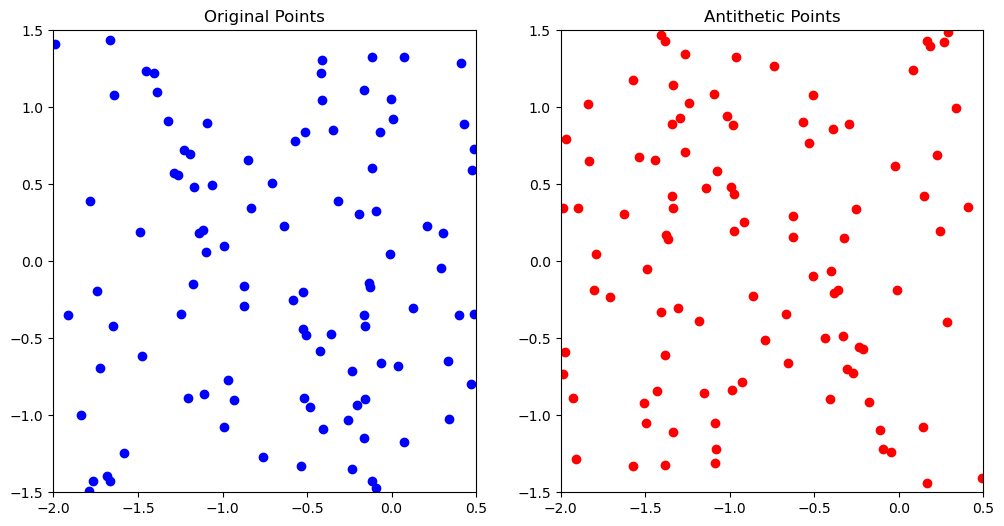

In [279]:
import numpy as np
import matplotlib.pyplot as plt

def anthithetic_variable(x_point, y_point ):
    bound_x = (-2, 0.5)
    bound_y = (-1.5, 1.5) 
    length_x = bound_x[1] - bound_x[0]
    length_y = bound_y[1] - bound_y[0]
    f_mirror = lambda bound, length, x : bound[1] - (x - bound[0])
    f_antithtic_x = lambda array: list(map(lambda x: f_mirror(bound_x, length_x, x), array))
    f_antithtic_y = lambda array: list(map(lambda x: f_mirror(bound_y, length_y, x), array))
    print("x point: ", x_point)
    antith_x = f_antithtic_x(x_point)
    antith_y = f_antithtic_y(y_point)
    print(antith_x)
    #print(antith_y)
    return antith_x, antith_y

def transform_points_to_complex(points):
    x_points = points[:, 0]
    y_points = points[:, 1]
    np.random.shuffle(y_points)
    np.random.shuffle(x_points)
    
    x_point_anti, y_points_anti = anthithetic_variable(x_points, y_points)
    """
    x_points = np.append(x_points, x_point_anti)
    y_points = np.append(y_points, y_points_anti)
    np.random.shuffle(y_points)
    np.random.shuffle(x_points)
    """
    return np.column_stack((x_point_anti, y_points_anti))

num_points = 100
x_min, x_max, y_min, y_max = -2, 0.5, -1.5, 1.5
original_points = np.random.uniform(low=(x_min, y_min), high=(x_max, y_max), size=(num_points, 2))
print("Origonal: ", original_points)
transformed_points = transform_points_to_complex(original_points)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(original_points[:, 0], original_points[:, 1], color='blue')
plt.title("Original Points")
plt.xlim([x_min, x_max])
plt.ylim([y_min, y_max])

plt.subplot(1, 2, 2)
plt.scatter(transformed_points[:, 0], transformed_points[:, 1], color='red')
plt.title("Antithetic Points")
plt.xlim([x_min, x_max])
plt.ylim([y_min, y_max])

plt.show()
